In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('questions.csv')
df.shape

(404351, 6)

In [3]:
# Reducing rows because number of rows are more
new_df = df.sample(30000,random_state=2)

In [4]:
new_df.head()

id    qid1    qid2  \
339499  339499  665522  665523   
289521  289521  568878  568879   
4665      4665    9325    9326   
54203    54203  107861  107862   
132566  132566  262554   91499   

                                                question1  \
339499  Why was Cyrus Mistry removed as the Chairman o...   
289521  By what age would you think a man should be ma...   
4665    How would an arbitrageur seek to capitalize gi...   
54203       Why did Quora mark my question as incomplete?   
132566  What is it like working with Pivotal Labs as a...   

                                                question2  is_duplicate  
339499         Why did the Tata Sons sacked Cyrus Mistry?             1  
289521  When my wrist is extended I feel a shock and b...             0  
4665    How would an arbitrageur seek to capitalize gi...             0  
54203   Why does Quora detect my question as an incomp...             1  
132566            What's it like to work at Pivotal Labs?             0

In [5]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q    


In [6]:
# checking how the function works
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [7]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [8]:
new_df.head()

id    qid1    qid2  \
339499  339499  665522  665523   
289521  289521  568878  568879   
4665      4665    9325    9326   
54203    54203  107861  107862   
132566  132566  262554   91499   

                                                question1  \
339499  why was cyrus mistry removed as the chairman o...   
289521  by what age would you think a man should be ma...   
4665    how would an arbitrageur seek to capitalize gi...   
54203        why did quora mark my question as incomplete   
132566  what is it like working with pivotal labs as a...   

                                                question2  is_duplicate  
339499          why did the tata sons sacked cyrus mistry             1  
289521  when my wrist is extended i feel a shock and b...             0  
4665    how would an arbitrageur seek to capitalize gi...             0  
54203   why does quora detect my question as an incomp...             1  
132566            what is it like to work at pivotal labs             0

In [9]:
new_df['q1_len'] = new_df['question1'].str.len() 
new_df['q2_len'] = new_df['question2'].str.len()

In [10]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df.head()

id    qid1    qid2  \
339499  339499  665522  665523   
289521  289521  568878  568879   
4665      4665    9325    9326   
54203    54203  107861  107862   
132566  132566  262554   91499   

                                                question1  \
339499  why was cyrus mistry removed as the chairman o...   
289521  by what age would you think a man should be ma...   
4665    how would an arbitrageur seek to capitalize gi...   
54203        why did quora mark my question as incomplete   
132566  what is it like working with pivotal labs as a...   

                                                question2  is_duplicate  \
339499          why did the tata sons sacked cyrus mistry             1   
289521  when my wrist is extended i feel a shock and b...             0   
4665    how would an arbitrageur seek to capitalize gi...             0   
54203   why does quora detect my question as an incomp...             1   
132566            what is it like to work at pivotal labs             0   

        q1_len  q2_len  q1_num_words  q2_num_words  
339499      57      41            11             8  
289521      51     104            11            23  
4665       123     122            42            42  
54203       44      59             8            10  
132566      53      39            11             9

In [11]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

In [12]:
new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()

id    qid1    qid2  \
339499  339499  665522  665523   
289521  289521  568878  568879   
4665      4665    9325    9326   
54203    54203  107861  107862   
132566  132566  262554   91499   

                                                question1  \
339499  why was cyrus mistry removed as the chairman o...   
289521  by what age would you think a man should be ma...   
4665    how would an arbitrageur seek to capitalize gi...   
54203        why did quora mark my question as incomplete   
132566  what is it like working with pivotal labs as a...   

                                                question2  is_duplicate  \
339499          why did the tata sons sacked cyrus mistry             1   
289521  when my wrist is extended i feel a shock and b...             0   
4665    how would an arbitrageur seek to capitalize gi...             0   
54203   why does quora detect my question as an incomp...             1   
132566            what is it like to work at pivotal labs             0   

        q1_len  q2_len  q1_num_words  q2_num_words  word_common  
339499      57      41            11             8            6  
289521      51     104            11            23            3  
4665       123     122            42            42           18  
54203       44      59             8            10            6  
132566      53      39            11             9            6

In [13]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [14]:
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()

id    qid1    qid2  \
339499  339499  665522  665523   
289521  289521  568878  568879   
4665      4665    9325    9326   
54203    54203  107861  107862   
132566  132566  262554   91499   

                                                question1  \
339499  why was cyrus mistry removed as the chairman o...   
289521  by what age would you think a man should be ma...   
4665    how would an arbitrageur seek to capitalize gi...   
54203        why did quora mark my question as incomplete   
132566  what is it like working with pivotal labs as a...   

                                                question2  is_duplicate  \
339499          why did the tata sons sacked cyrus mistry             1   
289521  when my wrist is extended i feel a shock and b...             0   
4665    how would an arbitrageur seek to capitalize gi...             0   
54203   why does quora detect my question as an incomp...             1   
132566            what is it like to work at pivotal labs             0   

        q1_len  q2_len  q1_num_words  q2_num_words  word_common  word_total  
339499      57      41            11             8            6          19  
289521      51     104            11            23            3          33  
4665       123     122            42            42           18          38  
54203       44      59             8            10            6          18  
132566      53      39            11             9            6          20

In [15]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

id    qid1    qid2  \
339499  339499  665522  665523   
289521  289521  568878  568879   
4665      4665    9325    9326   
54203    54203  107861  107862   
132566  132566  262554   91499   

                                                question1  \
339499  why was cyrus mistry removed as the chairman o...   
289521  by what age would you think a man should be ma...   
4665    how would an arbitrageur seek to capitalize gi...   
54203        why did quora mark my question as incomplete   
132566  what is it like working with pivotal labs as a...   

                                                question2  is_duplicate  \
339499          why did the tata sons sacked cyrus mistry             1   
289521  when my wrist is extended i feel a shock and b...             0   
4665    how would an arbitrageur seek to capitalize gi...             0   
54203   why does quora detect my question as an incomp...             1   
132566            what is it like to work at pivotal labs             0   

        q1_len  q2_len  q1_num_words  q2_num_words  word_common  word_total  \
339499      57      41            11             8            6          19   
289521      51     104            11            23            3          33   
4665       123     122            42            42           18          38   
54203       44      59             8            10            6          18   
132566      53      39            11             9            6          20   

        word_share  
339499        0.32  
289521        0.09  
4665          0.47  
54203         0.33  
132566        0.30

Advanced Features
1. Token Features
- cwc_min: This is the ratio of the number of common words to the length of the smaller question
- cwc_max: This is the ratio of the number of common words to the length of the larger question
- csc_min: This is the ratio of the number of common stop words to the smaller stop word count among the two questions
- csc_max: This is the ratio of the number of common stop words to the larger stop word count among the two questions
- ctc_min: This is the ratio of the number of common tokens to the smaller token count among the two questions
- ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions
- last_word_eq: 1 if the last word in the two questions is same, 0 otherwise
- first_word_eq: 1 if the first word in the two questions is same, 0 otherwise.

2. Length Based Features
- mean_len: Mean of the length of the two questions (number of words)
- abs_len_diff: Absolute difference between the length of the two questions (number of words)
- longest_substr_ratio: Ratio of the length of the longest substring among the two questions to the length of the smaller question

3. Fuzzy Features
-fuzz_ratio: fuzz_ratio score from fuzzywuzzy
- fuzz_partial_ratio: fuzz_partial_ratio from fuzzywuzzy
- token_sort_ratio: token_sort_ratio from fuzzywuzzy
- token_set_ratio: token_set_ratio from fuzzywuzzy

In [16]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features    

In [17]:
token_features = new_df.apply(fetch_token_features, axis=1)

new_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [18]:
new_df.head()

id    qid1    qid2  \
339499  339499  665522  665523   
289521  289521  568878  568879   
4665      4665    9325    9326   
54203    54203  107861  107862   
132566  132566  262554   91499   

                                                question1  \
339499  why was cyrus mistry removed as the chairman o...   
289521  by what age would you think a man should be ma...   
4665    how would an arbitrageur seek to capitalize gi...   
54203        why did quora mark my question as incomplete   
132566  what is it like working with pivotal labs as a...   

                                                question2  is_duplicate  \
339499          why did the tata sons sacked cyrus mistry             1   
289521  when my wrist is extended i feel a shock and b...             0   
4665    how would an arbitrageur seek to capitalize gi...             0   
54203   why does quora detect my question as an incomp...             1   
132566            what is it like to work at pivotal labs             0   

        q1_len  q2_len  q1_num_words  q2_num_words  ...  word_total  \
339499      57      41            11             8  ...          19   
289521      51     104            11            23  ...          33   
4665       123     122            42            42  ...          38   
54203       44      59             8            10  ...          18   
132566      53      39            11             9  ...          20   

        word_share   cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
339499        0.32  0.799984  0.666656  0.666644  0.399992  0.749991   
289521        0.09  0.000000  0.000000  0.499992  0.272725  0.272725   
4665          0.47  0.923070  0.923070  0.999980  0.999980  0.708330   
54203         0.33  0.749981  0.599988  0.749981  0.599988  0.749991   
132566        0.30  0.749981  0.599988  0.599988  0.499992  0.666659   

         ctc_max  last_word_eq  first_word_eq  
339499  0.545450             0              1  
289521  0.136363             0              0  
4665    0.708330             1              1  
54203   0.599994             0              1  
132566  0.545450             0              1  

[5 rows x 21 columns]

In [19]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features
    

In [20]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [21]:
new_df.head()

id    qid1    qid2  \
339499  339499  665522  665523   
289521  289521  568878  568879   
4665      4665    9325    9326   
54203    54203  107861  107862   
132566  132566  262554   91499   

                                                question1  \
339499  why was cyrus mistry removed as the chairman o...   
289521  by what age would you think a man should be ma...   
4665    how would an arbitrageur seek to capitalize gi...   
54203        why did quora mark my question as incomplete   
132566  what is it like working with pivotal labs as a...   

                                                question2  is_duplicate  \
339499          why did the tata sons sacked cyrus mistry             1   
289521  when my wrist is extended i feel a shock and b...             0   
4665    how would an arbitrageur seek to capitalize gi...             0   
54203   why does quora detect my question as an incomp...             1   
132566            what is it like to work at pivotal labs             0   

        q1_len  q2_len  q1_num_words  q2_num_words  ...   cwc_max   csc_min  \
339499      57      41            11             8  ...  0.666656  0.666644   
289521      51     104            11            23  ...  0.000000  0.499992   
4665       123     122            42            42  ...  0.923070  0.999980   
54203       44      59             8            10  ...  0.599988  0.749981   
132566      53      39            11             9  ...  0.599988  0.599988   

         csc_max   ctc_min   ctc_max  last_word_eq  first_word_eq  \
339499  0.399992  0.749991  0.545450             0              1   
289521  0.272725  0.272725  0.136363             0              0   
4665    0.999980  0.708330  0.708330             1              1   
54203   0.599988  0.749991  0.599994             0              1   
132566  0.499992  0.666659  0.545450             0              1   

        abs_len_diff  mean_len  longest_substr_ratio  
339499             3       9.5              0.309524  
289521            11      16.5              0.115385  
4665               0      24.0              0.593496  
54203              2       9.0              0.355556  
132566             2      10.0              0.400000  

[5 rows x 24 columns]

In [22]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [23]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [24]:
print(new_df.shape)
new_df.head()

(30000, 28)


id    qid1    qid2  \
339499  339499  665522  665523   
289521  289521  568878  568879   
4665      4665    9325    9326   
54203    54203  107861  107862   
132566  132566  262554   91499   

                                                question1  \
339499  why was cyrus mistry removed as the chairman o...   
289521  by what age would you think a man should be ma...   
4665    how would an arbitrageur seek to capitalize gi...   
54203        why did quora mark my question as incomplete   
132566  what is it like working with pivotal labs as a...   

                                                question2  is_duplicate  \
339499          why did the tata sons sacked cyrus mistry             1   
289521  when my wrist is extended i feel a shock and b...             0   
4665    how would an arbitrageur seek to capitalize gi...             0   
54203   why does quora detect my question as an incomp...             1   
132566            what is it like to work at pivotal labs             0   

        q1_len  q2_len  q1_num_words  q2_num_words  ...   ctc_max  \
339499      57      41            11             8  ...  0.545450   
289521      51     104            11            23  ...  0.136363   
4665       123     122            42            42  ...  0.708330   
54203       44      59             8            10  ...  0.599994   
132566      53      39            11             9  ...  0.545450   

        last_word_eq  first_word_eq  abs_len_diff  mean_len  \
339499             0              1             3       9.5   
289521             0              0            11      16.5   
4665               1              1             0      24.0   
54203              0              1             2       9.0   
132566             0              1             2      10.0   

        longest_substr_ratio  fuzz_ratio  fuzz_partial_ratio  \
339499              0.309524          39                  46   
289521              0.115385          26                  50   
4665                0.593496         100                  99   
54203               0.355556          74                  75   
132566              0.400000          76                  85   

        token_sort_ratio  token_set_ratio  
339499                67               85  
289521                35               37  
4665                 100               99  
54203                 74               89  
132566                78               84  

[5 rows x 28 columns]

<Figure size 1440x1440 with 0 Axes>

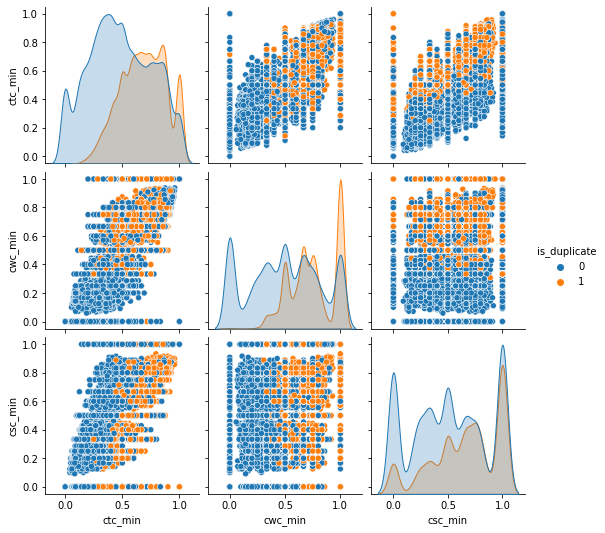

In [25]:
plt.figure(figsize=(20,20))
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

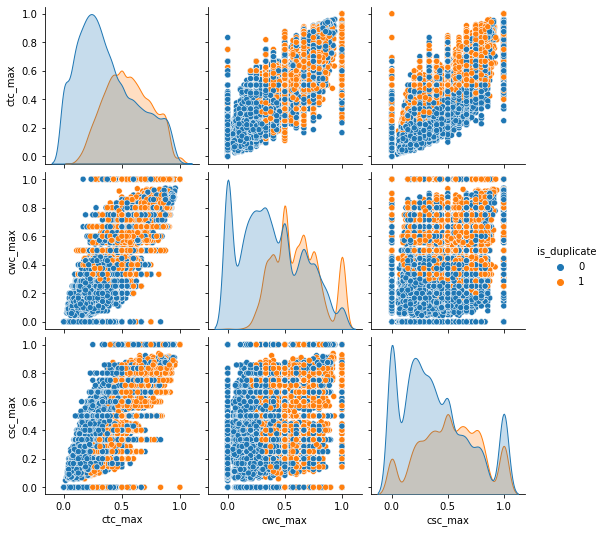

In [26]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

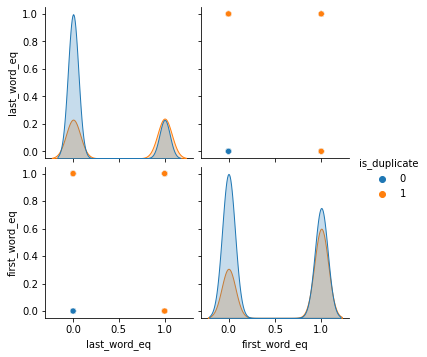

In [27]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

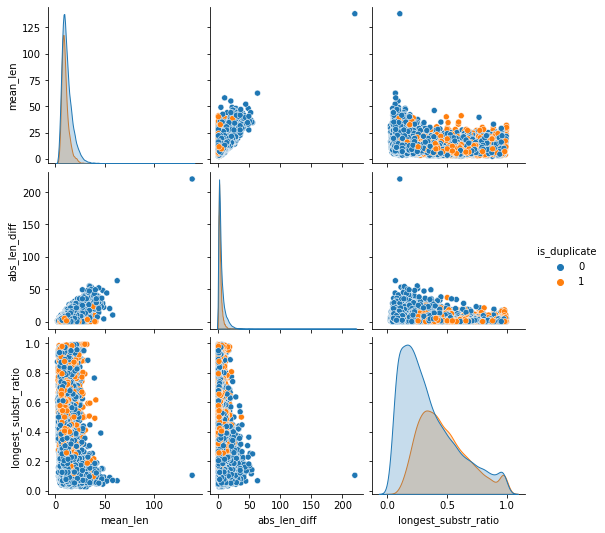

In [28]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

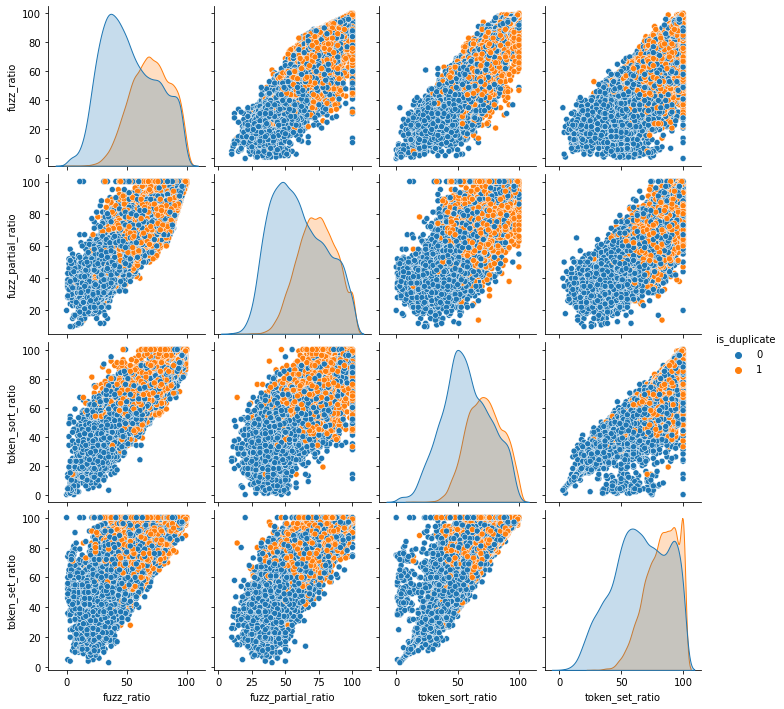

In [29]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [30]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(new_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = new_df['is_duplicate'].values

In [31]:
from sklearn.manifold import TSNE

tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.348s...
[t-SNE] Computed neighbors for 30000 samples in 7.902s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

In [32]:
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py
py.init_notebook_mode(connected=True)

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [33]:
ques_df = new_df[['question1','question2']]
ques_df.head()

question1  \
339499  why was cyrus mistry removed as the chairman o...   
289521  by what age would you think a man should be ma...   
4665    how would an arbitrageur seek to capitalize gi...   
54203        why did quora mark my question as incomplete   
132566  what is it like working with pivotal labs as a...   

                                                question2  
339499          why did the tata sons sacked cyrus mistry  
289521  when my wrist is extended i feel a shock and b...  
4665    how would an arbitrageur seek to capitalize gi...  
54203   why does quora detect my question as an incomp...  
132566            what is it like to work at pivotal labs

In [34]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(30000, 23)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  word_common  \
339499             1      57      41            11             8            6   
289521             0      51     104            11            23            3   
4665               0     123     122            42            42           18   
54203              1      44      59             8            10            6   
132566             0      53      39            11             9            6   

        word_total  word_share   cwc_min   cwc_max  ...   ctc_max  \
339499          19        0.32  0.799984  0.666656  ...  0.545450   
289521          33        0.09  0.000000  0.000000  ...  0.136363   
4665            38        0.47  0.923070  0.923070  ...  0.708330   
54203           18        0.33  0.749981  0.599988  ...  0.599994   
132566          20        0.30  0.749981  0.599988  ...  0.545450   

        last_word_eq  first_word_eq  abs_len_diff  mean_len  \
339499             0              1             3       9.5   
289521             0              0            11      16.5   
4665               1              1             0      24.0   
54203              0              1             2       9.0   
132566             0              1             2      10.0   

        longest_substr_ratio  fuzz_ratio  fuzz_partial_ratio  \
339499              0.309524          39                  46   
289521              0.115385          26                  50   
4665                0.593496         100                  99   
54203               0.355556          74                  75   
132566              0.400000          76                  85   

        token_sort_ratio  token_set_ratio  
339499                67               85  
289521                35               37  
4665                 100               99  
54203                 74               89  
132566                78               84  

[5 rows x 23 columns]

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

tf = TfidfVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(tf.fit_transform(questions).toarray(),2)

In [36]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [37]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(30000, 6023)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  word_common  \
339499             1      57      41            11             8            6   
289521             0      51     104            11            23            3   
4665               0     123     122            42            42           18   
54203              1      44      59             8            10            6   
132566             0      53      39            11             9            6   

        word_total  word_share   cwc_min   cwc_max  ...  2990  2991  2992  \
339499          19        0.32  0.799984  0.666656  ...   0.0   0.0   0.0   
289521          33        0.09  0.000000  0.000000  ...   0.0   0.0   0.0   
4665            38        0.47  0.923070  0.923070  ...   0.0   0.0   0.0   
54203           18        0.33  0.749981  0.599988  ...   0.0   0.0   0.0   
132566          20        0.30  0.749981  0.599988  ...   0.0   0.0   0.0   

        2993  2994  2995  2996  2997  2998  2999  
339499   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
289521   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4665     0.0   0.0   0.0   0.0   0.0   0.0   0.0  
54203    0.0   0.0   0.0   0.0   0.0   0.0   0.0  
132566   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 6023 columns]

In [38]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7835

In [40]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

[21:50:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7903333333333333

In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
# for random forest model
confusion_matrix(y_test,y_pred)

array([[3196,  631],
       [ 668, 1505]], dtype=int64)

In [43]:
# for xgboost model
confusion_matrix(y_test,y_pred1)

array([[3192,  635],
       [ 623, 1550]], dtype=int64)

In [44]:
tf

TfidfVectorizer(max_features=3000)

In [46]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [47]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

In [48]:
def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features

In [49]:
def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [50]:
def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [51]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_bow = tf.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = tf.transform([q2]).toarray()
    
    
    
    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

In [52]:
tf

TfidfVectorizer(max_features=3000)

In [53]:
import pickle

pickle.dump(rf,open('model.pkl','wb'))
pickle.dump(tf,open('tf.pkl','wb'))

In [54]:
from nltk.corpus import stopwords

STOP_WORDS = stopwords.words("english")

pickle.dump(STOP_WORDS, open('stopwords.pkl', 'wb'))